<a href="https://colab.research.google.com/github/tonyzamyatin/learning-pytorch/blob/master/03_computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 03. PyTorch Computer Vision

Online Course Book: https://www.learnpytorch.io/03_pytorch_computer_vision/

In [1]:
# Import PyTorch
import torch

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.4.0
torchvision version: 0.19.0


In [2]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
    print("Downloading helper_functions.py")
    # Note: you need the "raw" GitHub URL for this to work
    request = requests.get("https://raw.githubusercontent.com/tonyzamyatin/learning-pytorch/master/fcc-course/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

## 1. Getting a dataset
For our first computer vision task we will go with the glorious FashionMNIST dataset, made by Zalando research. It contains low resolution grey scale images of 10 different kinds of clothing.

In [2]:
# Setup training data
train_data = datasets.FashionMNIST(
    root="data",  # where to download data
    train=True,  # get training data
    download=True,  # download data if it doesn't exist on disk
    transform=ToTensor(),  # images come as PIL format, we want to turn into Torch tensors
    target_transform=None  # don't transform the labels though
)

# Setup test data
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

Let's inspect the first sample of the training data.

In [3]:
image, label = train_data[0]
image, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

### 1.1 Input and output shapes of a computer vision model

In [4]:
image.shape

torch.Size([1, 28, 28])

We have one color channel and a width and height of 28 pixels.

There is debate whether CHW or HWC is the better way to represent an image. Anyway, PyTorch accepts NCHW as default, but at the same time explains that NHWC performs better and is considered best practice.

In [5]:
# Number of samples
len(train_data), len(test_data)

(60000, 10000)

We have 60k training images and 10k test images.

In [6]:
# Inspect available classes
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

Since we have 10 different classes. we're dealing with a multi-classification problem yet again.

### 1.2 Visualize and explore our data

Image shape: torch.Size([1, 28, 28])


(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

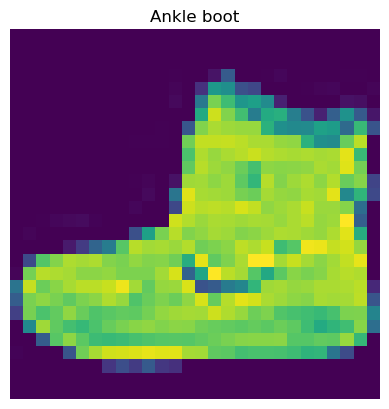

In [7]:
import matplotlib.pyplot as plt

image, label = train_data[0]
print(f"Image shape:", image.shape)
plt.imshow(image.squeeze())
plt.title(class_names[label])
plt.axis(False)

To turn images into greyscale we use the ˋcmapˋ parameter of ˋplt.imshow()ˋ.

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

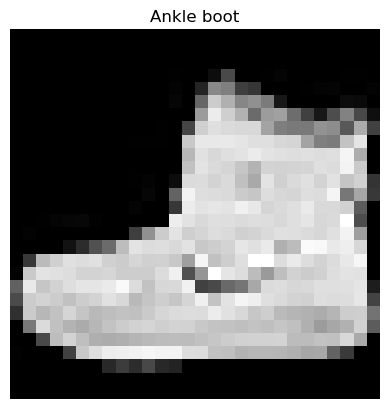

In [8]:
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)

Let's plot some more images.

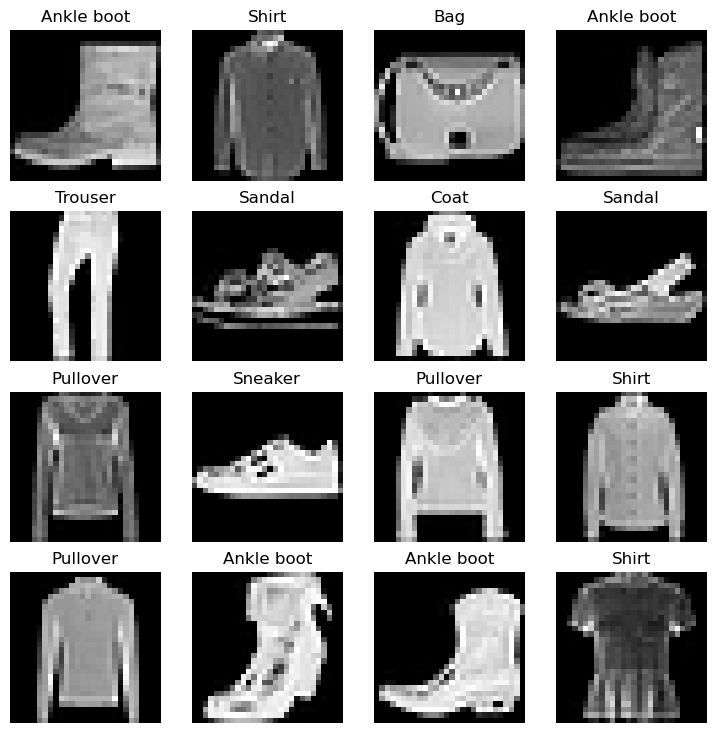

In [9]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)


Let's have a look at the class distribution of our datasets.

In [10]:
def get_mnist_class_count(dataset: torchvision.datasets.MNIST):
    """
    Count the classes of an MNIST dataset.
    :param dataset: A dataset subclassing `torchvision.datasets.mnist.MNIST`
    :return: a dictionary of the class names and their frequency in the dataset
    """
    class_count = {name: 0 for name in dataset.classes}
    for img, label in dataset:
        class_count[dataset.classes[label]] += 1
    
    return class_count

In [28]:
train_class_count = get_mnist_class_count(train_data)
print(f"Train data class count:\n{train_class_count}")
test_class_count = get_mnist_class_count(test_data)
print(f"Test data class count:\n{test_class_count}")

Train data class count:
{'T-shirt/top': 6000, 'Trouser': 6000, 'Pullover': 6000, 'Dress': 6000, 'Coat': 6000, 'Sandal': 6000, 'Shirt': 6000, 'Sneaker': 6000, 'Bag': 6000, 'Ankle boot': 6000}
Test data class count:
{'T-shirt/top': 1000, 'Trouser': 1000, 'Pullover': 1000, 'Dress': 1000, 'Coat': 1000, 'Sandal': 1000, 'Shirt': 1000, 'Sneaker': 1000, 'Bag': 1000, 'Ankle boot': 1000}


The classes of our datasets are nicely evenly distributed.

**Note**: This is a toy dataset and in real world scenarios we will likely have to deal with skewed data distributions.

## 2. Prepare DataLoader

In [11]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dl = DataLoader(train_data, batch_size=BATCH_SIZE)
test_dl = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)
print(f"Data loaders: {train_dl, test_dl}")
print(f"Length of train data loader: {len(train_dl)} batches of {BATCH_SIZE}...")
print(f"Length of test data loader: {len(test_dl)} batches of {BATCH_SIZE}...")

Data loaders: (<torch.utils.data.dataloader.DataLoader object at 0x7fe991e06140>, <torch.utils.data.dataloader.DataLoader object at 0x7fe991e063e0>)
Length of train data loader: 1875 batches of 32...
Length of test data loader: 313 batches of 32...


## 3. Build a baseline model


In [12]:
from torch import nn


class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, hidden_units),
            nn.Linear(hidden_units, output_shape)
        )

    def forward(self, x):
        return self.layer_stack(x)

In [13]:
torch.manual_seed(42)

model_0 = FashionMNISTModelV0(
    input_shape=784,
    hidden_units=10,
    output_shape=len(class_names)).to("cpu")

### 3.1 Setup loss, optimizer and evaluation metrics

In [14]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.01)

### 3.2 Creating a function to time our experiments
Let's do a small experiment and compare the time it takes to run the model on a GPU versus on a CPU.

Our timing function will use ˋtimeit.default_timer()ˋ from the ˋtimeitˋ module.

In [15]:
from timeit import default_timer as timer


def print_train_time(start: float, end: float, device: torch.device = None):
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

### 3.3 Training loop on batches of data

In [16]:
from tqdm.auto import tqdm

torch.manual_seed(42)

# Measure time
train_time_start_on_cpu = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch + 1}\n---------")
    train_loss = 0
    for batch, (X, y) in enumerate(train_dl):
        model_0.train()
        y_pred = model_0(X)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dl.dataset)} samples")

    # Average loss per batch per epoch
    train_loss /= len(train_dl)

    # Testing
    test_loss, test_acc = 0, 0
    model_0.eval()
    with torch.inference_mode():
        for X_test, y_test in test_dl:
            test_pred = model_0(X_test)
            test_loss += loss_fn(test_pred, y_test)
            test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))

        test_loss /= len(test_dl)
        test_acc /= len(test_dl)

    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

# Calculate training time
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(
    start=train_time_start_on_cpu,
    end=train_time_end_on_cpu,
    device="cpu"
)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1
---------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.00000 | Test loss: 0.50305, Test acc: 81.85%

Epoch: 2
---------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.00000 | Test loss: 0.50263, Test acc: 82.33%

Epoch: 3
---------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.00000 | Test loss: 0.51653, Test acc: 81.99%

Train time on cpu: 24.313 seconds


The baseline model did already do quite well. Let's evaluate the model.

## 4. Evaluate Model 0

In [ ]:
!pip install torchmetrics

EVALUATION of FashionMNISTModelV0
Loss: 0.5165
Accuracy: 0.8199
Auroc: 0.9810
F1-score: 0.8170
Precision: 0.8232
Recall: 0.8199


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Predicted class', ylabel='True class'>)

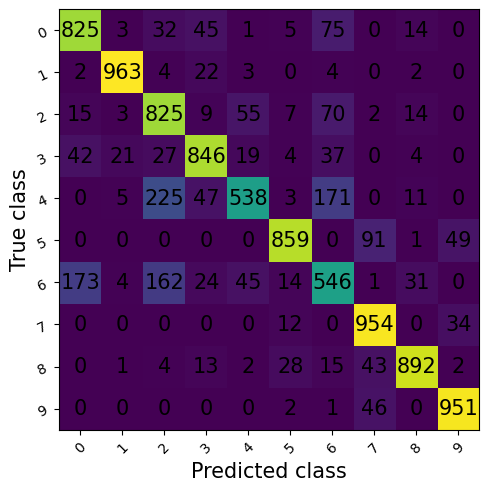

In [18]:
from helper_functions import print_eval_metrics, eval_model
from torchmetrics import MetricCollection, Accuracy, Recall, Precision, F1Score, AUROC, ConfusionMatrix

metrics = MetricCollection({
        "accuracy": Accuracy(task="multiclass", num_classes=10, average='macro'),
        "recall": Recall(task="multiclass", num_classes=10, average='macro'),
        "precision": Precision(task="multiclass", num_classes=10, average='macro'),
        "f1-score": F1Score(task="multiclass", num_classes=10, average='macro'),
        "auroc": AUROC(task="multiclass", num_classes=10),
        "confmat": ConfusionMatrix(task="multiclass", num_classes=10)
})

loss, updated_metrics = eval_model(model_0, test_dl, loss_fn, metrics)
computed_metrics = {name: metric.compute() for name, metric in updated_metrics.items() if name != "confmat"}

print(f"EVALUATION of {model_0.__class__.__name__}")
print_eval_metrics(loss, computed_metrics)

metrics['confmat'].plot()

In [19]:
# Save model
from pathlib import Path
MODELS_DIR_PATH = Path("models")
MODEL_NAME_0 = "03_pytorch_cv_model_0.pth"
MODELS_DIR_PATH.mkdir(parents=True, exist_ok=True)
MODEL_SAVE_PATH_0 = MODELS_DIR_PATH / MODEL_NAME_0
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH_0)

## 5. Setup device agnostic-code

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 6. Model 1: Building a better model with non-linearity

In [21]:
class FashionMNISTModelV1(nn.Module):
    def __init__(self, input_size: int, hidden_units: int, output_size: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, output_size),
            nn.ReLU()
        )
    
    def forward(self, x):
        return self.layer_stack(x)

In [22]:
torch.manual_seed(42)

model_1 = FashionMNISTModelV1(28**2, 10, len(class_names)).to(device)

### 6.1 Setup loss, optimizer and metrics

In [23]:
from torchmetrics.wrappers import MetricTracker
from torchmetrics import MetricCollection, ConfusionMatrix, AUROC, F1Score, Precision, Recall, Accuracy

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.01)

train_metrics = MetricCollection({
    'accuracy': Accuracy(task="multiclass", num_classes=10, average='macro'),
    'f1_score': F1Score(task="multiclass", num_classes=10, average='macro')
})

test_metrics = MetricCollection({
    'accuracy': Accuracy(task="multiclass", num_classes=10, average='macro'),
    'recall': Recall(task="multiclass", num_classes=10, average='macro'),
    'precision': Precision(task="multiclass", num_classes=10, average='macro'),
    'f1_score': F1Score(task="multiclass", num_classes=10, average='macro'),
    'auroc': AUROC(task="multiclass", num_classes=10, average='macro'),
    'confmat': ConfusionMatrix(task="multiclass", num_classes=10)
})

train_metric_tracker = MetricTracker(train_metrics)
test_metric_tracker = MetricTracker(test_metrics)

## 6.2 Create training and testing loop
I defined to functions `run_epoch()` and `plot_confusion_matrix()` in `helper_functions.py` to simplify the training-testing loop.

  0%|          | 0/3 [00:00<?, ?it/s]


EPOCH 1
---------
Training metrics:
Loss: 1.1798
Accuracy: 0.5959
F1_score: 0.5167

Test metrics:
Loss: 1.1303
Accuracy: 0.6031
Auroc: 0.9318
F1_score: 0.5256
Precision: 0.4870
Recall: 0.6031

EPOCH 2
---------
Training metrics:
Loss: 1.1055
Accuracy: 0.6124
F1_score: 0.5364

Test metrics:
Loss: 1.1314
Accuracy: 0.6037
Auroc: 0.9331
F1_score: 0.5252
Precision: 0.4871
Recall: 0.6037

EPOCH 3
---------
Training metrics:
Loss: 1.0881
Accuracy: 0.6159
F1_score: 0.5405

Test metrics:
Loss: 1.1398
Accuracy: 0.6057
Auroc: 0.9339
F1_score: 0.5265
Precision: 0.4892
Recall: 0.6057
Confusion Matrix:


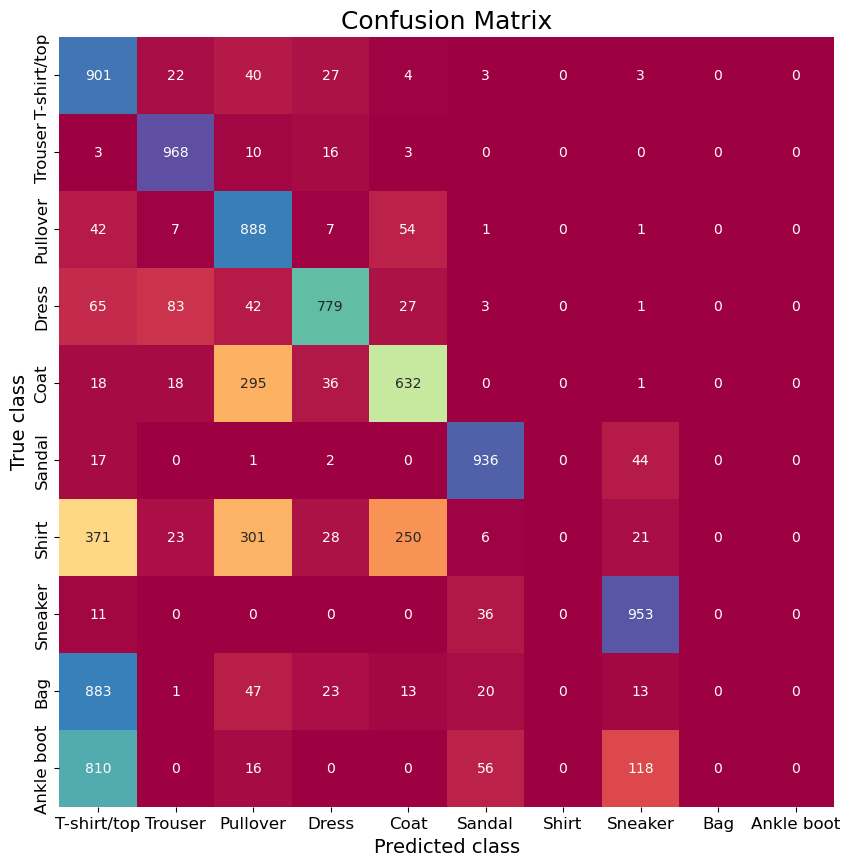


Train time on cuda: 30.268 seconds


In [24]:
torch.manual_seed(42)

from timeit import default_timer as timer
from helper_functions import plot_confusion_matrix, run_epoch
train_time_start_on_gpu = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"\nEPOCH {epoch+1}\n---------")
    train_loss, train_metric_tracker = run_epoch(
        model=model_1,
        data_loader=train_dl,
        loss_fn=loss_fn,
        optimizer=optimizer,
        metric_tracker=train_metric_tracker,
        device=device
    )
    computed_train_metrics = train_metric_tracker.compute()
    print("Training metrics:")
    print_eval_metrics(train_loss, computed_train_metrics)
    
    test_loss, test_metric_tracker = run_epoch(
        model=model_1,
        data_loader=test_dl,
        loss_fn=loss_fn,
        metric_tracker=test_metric_tracker,
        device=device
    )
    
    computed_test_metrics = test_metric_tracker.compute()
    print("\nTest metrics:")
    print_eval_metrics(test_loss, {k: v for k, v in computed_test_metrics.items() if k != 'confmat'})
    
    if epoch == epochs - 1:
        confusion_matrix = computed_test_metrics['confmat']
        plot_confusion_matrix(confusion_matrix, class_names)
        
train_time_end_on_gpu = timer()
print()
total_train_time_model_1 = print_train_time(train_time_start_on_gpu, train_time_end_on_gpu, device)


Awesome! But it looks like it longer to train the model on the GPU than on the CPU. How can that be?
> Well, one reason could be because your dataset and model are both so small (like the dataset and model we're working with) the benefits of using a
 GPU are outweighed by the time it actually takes to transfer the data there. There's a small bottleneck between copying data from the CPU memory (default) to the GPU memory. So for smaller models and datasets, the CPU might
  actually be the optimal place to compute on.
But for larger datasets and models, the speed of computing the GPU can offer usually far outweighs the cost of getting the data there.
However, this is largely dependant on the hardware you're using. With practice, you will get used to where the best place to train your models is.

In [25]:
# Save model
MODEL_NAME_1 = "03_pytorch_cv_model_1.pth"
MODEL_SAVE_PATH_1 = MODELS_DIR_PATH / MODEL_NAME_1

torch.save(obj=model_1, f=MODEL_SAVE_PATH_1)

Let's compare the two models!

In [27]:
test_metrics.reset()
loss_0, test_metrics_0 = eval_model(model_0, test_dl, loss_fn, test_metrics)
eval_0 = {name: metric.compute() for name, metric in test_metrics_0.items() if name != "confmat"}

test_metrics.reset()
loss_1, test_metrics_1 = eval_model(model_1, test_dl, loss_fn, test_metrics)
eval_1 = {name: metric.compute() for name, metric in test_metrics_1.items() if name != "confmat"}

print(f"EVALUATION of {model_0.__class__.__name__}")
print_eval_metrics(loss_0, eval_0)
print(f"\nEVALUTATION of {model_1.__class__.__name__}")
print_eval_metrics(loss_1, eval_1)

EVALUATION of FashionMNISTModelV0
Loss: 0.5165
Accuracy: 0.8199
Auroc: 0.9810
F1_score: 0.8170
Precision: 0.8232
Recall: 0.8199

EVALUTATION of FashionMNISTModelV1
Loss: 1.1398
Accuracy: 0.6057
Auroc: 0.9339
F1_score: 0.5265
Precision: 0.4892
Recall: 0.6057


Interesting. In this case, it looks like adding non-linearity to our model made it perform worse than the baseline.

> That's a thing to note in machine learning, sometimes the thing you thought should work doesn't. And then the thing you thought might not work does.

Most likely, the model is overfitting to the training data.

Two main (simplest) ways to fix overfitting include:
1. Use a smaller or different model (some models fir certain kinds of data better than others)
2. Use a larger dataset (the more data, the more chance the model has to learn generalizable patterns)

There are also more ways to prevent overfitting in machine learning (e.g. regularization). Researching this is part of the extracurricular.

In the meantime, we will try method 1 - using a different model architecture.

## 7. Model 2: Build a Convolutional Neural Network (CNN)
CNNs are known for their capacity to find patterns in visual data (although their application extends way beyond just images).

Let's see if a CNN model can improve upon our baseline. The CNN model we're going to be using it known as TinyVGG from https://poloclub.github.io/cnn-explainer.

It follows the typical structure of a CNN:

`Input layer -> [Convolutional layer -> activation layer -> pooling layer] -> Output layer`

The convolutional blocks can be upscaled and repeated multiple times, depending on requirements.

### What model to use?

| Problem type                          | Model to use (generally)                          | Code example                           |
|---------------------------------------|---------------------------------------------------|----------------------------------------|
| Structured data (Excel spreadsheets, row and column data) | Gradient boosted models, Random Forests, XGBoost | sklearn.ensemble, XGBoost library      |
| Unstructured data (images, audio, language) | Convolutional Neural Networks, Transformers       | torchvision.models, HuggingFace Transformers |

This is only a tiny, arbitrarily picked set of models. In reality, there are many more and the one to use depends on the problem at hand and the 
specific project requirements.

In [37]:
class FashionMNISTModelV2(nn.Module):
    def __init__(self, input_size: int, hidden_units: int, output_size: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_size,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                           stride=2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_size)
        )
        
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
    
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(1, 10, len(class_names)).to(device)

model_2

FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

Nice! This is the biggest model of the course yet.

What we have done is common practice in machine learning:

"Find a model architecture somewhere and replicate it with code."

### CNN architecture

The two new layers we use in a CNN are the convolutional layer and the max-pooling layer:
- `nn.Conv2d`: the convolutional layer performs a two-dimensional convolution on the input tensor. There are also 1D and 3D convolutions 
implemented in PyTorch. To understand what a convolution is, how it works inside CNNs and what the hyperparameters mean, see:[CNN Explainer 
website](https://poloclub.github.io/cnn-explainer/), [CNNs Explained](https://youtu.be/pj9-rr1wDhM?si=U9EoZQDSyJIWVQlD), and [But what is a 
convolution?](https://youtu.be/KuXjwB4LzSA?si=kSr1_3yI-VOnuR3r).
- `nn.MaxPool2d`: the max-pooling layer performs further compression of the convolutional layer output by moving another kernel over the input 
and only selecting (pooling) the maximum value inside the kernel into the output tensor. For a visual explainer see [CNNs Explained](https://youtu
.be/pj9-rr1wDhM?si=U9EoZQDSyJIWVQlD).

### 7.3 Setup a loss function, optimizer and metrics for Model 2

In [38]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_2.parameters(), lr=0.01)

train_metric_tracker.reset_all()
test_metric_tracker.reset()

### 7.4 Train and test Model 2


  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 1
---------
TRAINING:
Loss: 0.4735
Accuracy: 0.8278
F1_score: 0.8266
TESTING:
Loss: 0.4236
Accuracy: 0.8452
Auroc: 0.9861
F1_score: 0.8404
Precision: 0.8497
Recall: 0.8452
EPOCH 2
---------
TRAINING:
Loss: 0.3777
Accuracy: 0.8630
F1_score: 0.8622
TESTING:
Loss: 0.3868
Accuracy: 0.8618
Auroc: 0.9877
F1_score: 0.8566
Precision: 0.8634
Recall: 0.8618
EPOCH 3
---------
TRAINING:
Loss: 0.3626
Accuracy: 0.8670
F1_score: 0.8663
TESTING:
Loss: 0.3856
Accuracy: 0.8599
Auroc: 0.9879
F1_score: 0.8551
Precision: 0.8628
Recall: 0.8599


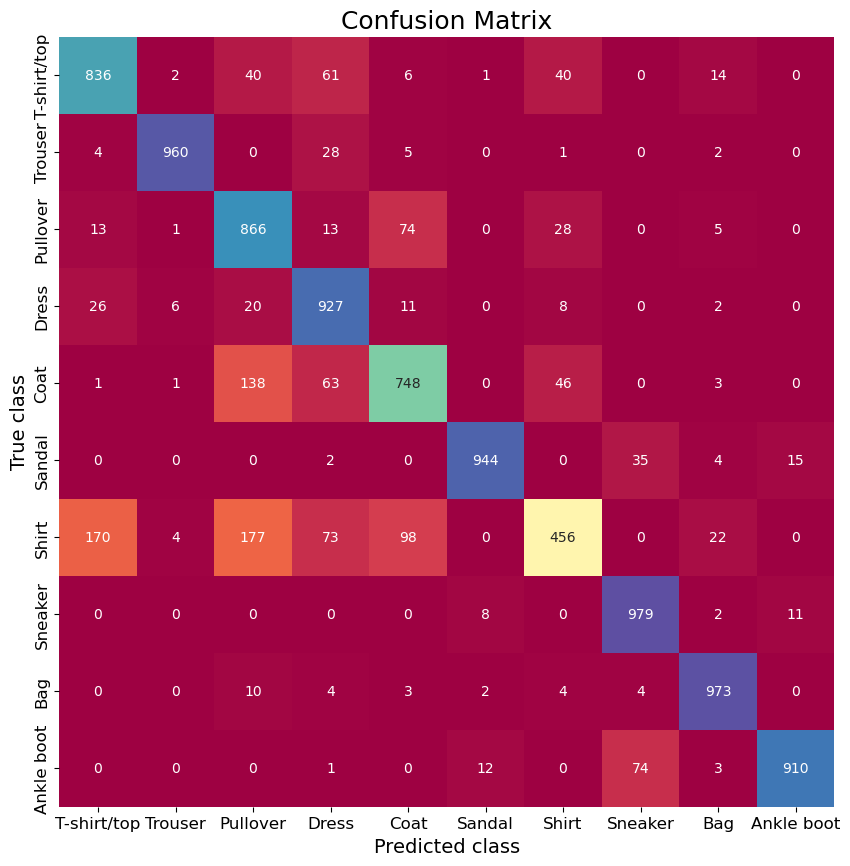

Train time on cuda: 34.145 seconds


In [39]:
torch.manual_seed(42)

from timeit import default_timer as timer
from helper_functions import run_epoch, plot_confusion_matrix
train_time_start_model_2 = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"\nEPOCH {epoch+1}\n---------")
    train_loss, train_metric_tracker = run_epoch(model_2, train_dl, loss_fn, optimizer, train_metric_tracker, device)
    computed_train_metrics = train_metric_tracker.compute()
    print("TRAINING:")
    print_eval_metrics(train_loss, computed_train_metrics)
    
    test_loss, test_metric_tracker = run_epoch(model_2, test_dl, loss_fn, optimizer=None, metric_tracker=test_metric_tracker, device=device)
    computed_test_metrics = test_metric_tracker.compute()
    print("TESTING:")
    print_eval_metrics(test_loss, {k: v for k, v in computed_test_metrics.items() if k != 'confmat'})
    
    if epoch == epochs - 1:
        confusion_matrix = computed_test_metrics['confmat']
        plot_confusion_matrix(confusion_matrix, class_names)
   
train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(train_time_start_model_2, train_time_end_model_2, device)

In [41]:
test_metrics.reset()
loss_2, test_metrics_2 = eval_model(model_2, test_dl, loss_fn, test_metrics)
eval_2 = {name: metric.compute() for name, metric in test_metrics_2.items() if name != "confmat"}

## 8. Compare model results and training time
We've trained three different models:
1. `model_0` - our baseline model with two `nn.Linear()` layers.
2. `model_1` - the same setup as the baseline model except that it uses `nn.ReLU()` as activation function
3. `model_2` - our CNN that mimics TinyVGG architecture on the CNN Explainer website

This is a regular practice in ML: Build multiple models and perform multiple training experiments to see which performs best.

Let's combine the model results into a data frame and find out.

In [50]:
import pandas as pd
from typing import Dict

def format_eval(eval: Dict[str, torch.Tensor]):
    return {k.capitalize(): f"{100 * v.item():.2f}%" for k, v in eval.items()}


model_benchmark = pd.DataFrame([
    format_eval(eval_0), 
    format_eval(eval_1), 
    format_eval(eval_2)
])
model_benchmark['Training time'] = [
    f"{total_train_time_model_0:.1f} s",
    f"{total_train_time_model_1:.1f} s",
    f"{total_train_time_model_2:.1f} s"
]
model_benchmark

,Accuracy,Auroc,F1_score,Precision,Recall,Training time
0,81.99%,98.10%,81.70%,82.32%,81.99%,24.3 s
1,60.57%,93.39%,52.65%,48.92%,60.57%,30.3 s
2,85.99%,98.79%,85.51%,86.28%,85.99%,34.1 s


It looks like our CNN model performed the best but also was the slowest during training. And our baseline model performed better then `model_1`.

### Performance-speed tradeoff
Something to be aware of in machine learning is the **performance-speed** tradeoff.

Generally, you get better performance out of a larger, more complex model (like our CNN). However, this kind of performance increase often comes at
 a sacrifice of training and inference speed, and at the risk of overfitting to the dataset used to train and evaluate the model.

## 9. Plot a confusion matrix

In [ ]:
# First make some predictions
y_preds = []
model_2.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dl, desc="Making predictions"):
        X, y = X.to(device), y.to(device)
        y_logit = model_2(X)
        y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
        y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

In [52]:
# See if mlxtend exists, if not, install it
try:
    import mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 64.8 MB/s eta 0:00:00


In [ ]:
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(task='multiclass', num_classes=len(class_names))
confmat_tensor = confmat(y_pred_tensor, test_data.targets)

fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
)

## 10. Save and load best performing model

In [ ]:
from pathlib import Path

MODELS_DIR_PATH = Path('models')
MODELS_DIR_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME_2 = "03_pytorch_cv_model_2.pth"
MODEL_SAVE_PATH_2 = MODELS_DIR_PATH / MODEL_NAME_2

torch.save(obj=model_2.state_dict(), f=MODEL_SAVE_PATH_2)